# Генсим и остальные неприятности

## Импорты и подготовка

используемые данные: наш семинар, туториалы на медиуме (https://medium.com/@kurtsenol21/topic-modeling-lda-mallet-implementation-in-python-part-1-c493a5297ad2 - зачем-то же мне нужна на него подписка), молитвы древним богам, точно не домашки никаких из моих сокурсников

первым шагом в одной ячейке и импортируем все библиотеки, и сразу стягиваем из них все, что нам нужно

In [6]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

import re

import numpy as np

import pandas as pd

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Эрнеста\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ознакомимся с нашим датасетом - загрузим его в панды, по красивой пандовской традиции всяких датасайентистов назовем датафреймом.

что у нас в его верхушке?

In [7]:
#это было у нас в семинаре, да и в любом курсе по нейросетям или датасайенсу
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


## Очистка данных

Почистим эти данные

In [8]:
#это было у нас чуть ли не со второго курса - и да, в семинаре
data = df.content.values.tolist()

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

data = [re.sub('\s+', ' ', sent) for sent in data]

data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


парсим предложения до уровня слов, которые можно будет скормить препроцессингу генсима

In [9]:
#было в семинаре
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Генсим

Мы дошли до генсима! Пойдем попросим его скрафтить биграммы и триграммы

In [10]:
#было в семинаре! а уж откуда оно в семинаре, одним древним богам ведомо
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


Теперь создадим функции для обращения к генсиму

In [11]:
#ой, а это забавно - это на медиуме было, ссылочка в первой ячейке. 
#Ну, и по традиции - и у нас в семинаре, правда, в разложенном на разные функции виде
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [14]:
texts = process_words(data_words)
print(texts[:1])

[['thing', 'car', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [15]:
#из семинара
id2word = corpora.Dictionary(texts)
print('Total Vocabulary Size:', len(id2word))

corpus = [id2word.doc2bow(text) for text in texts]

Total Vocabulary Size: 38795


In [16]:
#а вы мне сильно по башке надаете, если я последую дальше по статье, а не по семинару?
#мне тоже нравится идея отфильтровать самые частые и самые редкие слова, чтобы не забивать модель малозначимой информацией
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

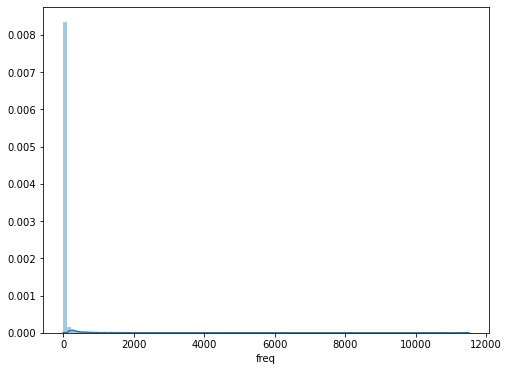

In [17]:
#как и идея глянуть на графике частотность, чтобы отсеять самые частые
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100)

In [19]:
dict_df.sort_values('freq', ascending=False).head(10)

,freq
line,11518
write,9999
would,9541
say,7029
know,6345
people,5942
make,5786
article,5775
think,5573
get,5216


In [20]:
extension = dict_df[dict_df.freq>4000].index.tolist()
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
texts = process_words(data_words)
# recreate Dictionary
id2word = corpora.Dictionary(texts)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 38656


In [63]:
id2word.filter_extremes(no_below=10, no_above=0.5)
print('Total Vocabulary Size:', len(id2word))
corpus = [id2word.doc2bow(text) for text in texts]

Total Vocabulary Size: 6689


Попробуем запустить маллет - вдруг именно у нас получится?

In [68]:
#это из туториалов по маллету
import os
os.environ['MALLET_HOME'] = 'C:/mallet-2.0.8'

In [69]:
#это из формулировки нашей домашки
mallet_path = 'C:/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

CalledProcessError: Command 'C:/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\BCD4~1\AppData\Local\Temp\d2fb3d_corpus.txt --output C:\Users\BCD4~1\AppData\Local\Temp\d2fb3d_corpus.mallet' returned non-zero exit status 1.

Факир был пьян, и фокус не удался. Даже если сделать все, что советует стаковерфлоу - изменить маллет.бат, натыкать его носом в конкретный путь до Джавы, вообще изменить расположение маллета - все равно все падает. Возвращаемся к обычному генсиму.

А теперь создаем функцию, которая найдет нам лучшие параметры

In [60]:
#это же вроде очевидная функция?..
#просто зациклить определение кохерентности, оставить лучший результат
def choose_score(start, end, step, corpus, id2word, texts):
    best_coh = 0
    best_num = 0
    for i in range(start, end, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

        coherence_lda_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_lda_model.get_coherence()
        if coherence_lda > best_coh:
            best_coh = coherence_lda
            best_num = i
            best_model = lda_model
            print(best_coh, best_num)

    return (best_coh, best_num, best_model)

In [61]:
choose_score(5, 50, 5, corpus, id2word, texts)

0.44511491720100127 5
0.490833259504702 10


(0.490833259504702, 10, <gensim.models.ldamodel.LdaModel at 0x282ee71c5c8>)

Сама функция для генсимовской модели! теперь с определенным нами лучшим числом групп

In [62]:
#из семинара
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
doc_lda = lda_model[corpus]
t = lda_model.get_topics()

In [18]:
list(t)

[(0,
  '0.028*"team" + 0.027*"year" + 0.026*"game" + 0.020*"play" + 0.018*"win" + 0.014*"player" + 0.010*"run" + 0.010*"last" + 0.009*"good" + 0.009*"hit"'),
 (1,
  '0.022*"go" + 0.015*"time" + 0.013*"day" + 0.012*"come" + 0.011*"take" + 0.011*"back" + 0.011*"get" + 0.009*"say" + 0.008*"see" + 0.008*"first"'),
 (2,
  '0.014*"space" + 0.008*"cost" + 0.008*"year" + 0.007*"high" + 0.007*"research" + 0.007*"low" + 0.006*"item" + 0.006*"also" + 0.006*"test" + 0.005*"large"'),
 (3,
  '0.033*"car" + 0.021*"drive" + 0.013*"bike" + 0.011*"power" + 0.011*"wire" + 0.011*"slave" + 0.010*"reality" + 0.009*"speed" + 0.009*"engine" + 0.009*"light"'),
 (4,
  '0.090*"ax" + 0.077*"max" + 0.018*"di_di" + 0.015*"tumor" + 0.012*"homosexual" + 0.011*"gay" + 0.009*"taste" + 0.008*"liar" + 0.007*"marry" + 0.006*"homosexuality"'),
 (5,
  '0.017*"government" + 0.013*"people" + 0.012*"gun" + 0.011*"state" + 0.010*"kill" + 0.008*"year" + 0.007*"public" + 0.007*"attack" + 0.007*"patient" + 0.007*"country"'),
 (6,


Мы дошли до определения списка слов в топиках!

In [19]:
#довольно очевидный цикл, мы такие на втором курсе писали. Хотя меня печалит наличие двух циклов - на производительность плохо влияет.
#если все будет сильно плохо, придется в колаб переходить
topic_dict = {}
for topic in list(t):
    topic = tuple(topic)
    new_top = {}
    for word in topic[1].split(' + '):
        word = word.split('*')
        new_top[word[1].strip('\"\"')] = float(word[0])
    topic_dict[topic[0]] = new_top

In [20]:
topic_dict[0]

{'game': 0.026,
 'good': 0.009,
 'hit': 0.009,
 'last': 0.01,
 'play': 0.02,
 'player': 0.014,
 'run': 0.01,
 'team': 0.028,
 'win': 0.018,
 'year': 0.027}

Это был список слов для топика спорт? Как мило

In [21]:
#это то, что нам предложили сделать в формулировке домашки
text_topics = []
for text in data_lemmatized:
    count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for word in text:
        for topic, lemmas in topic_dict.items():
            for lemm in lemmas:
                if lemm == word:
                    count[topic] += lemmas[lemm]
    text_topics.append(count.index(max(count)))

In [22]:
if len(text_topics)==len(texts):
  print('Carry on')

Carry on


Из плохих новостей: я достаточно плохо понимаю, что делать с ТФ-ИДФ.
Из хороших - я могу сказать, что такое coherence score!

coherence score это довольно интересный пайплайн для определения правильности найденного топика
он состоит из четырех компонентов: сегментация, оценка вероятности, оценка подтвержденности и аггрегация всех предыдущих в одно число, вроде АУК или аккьюраси нейросетки, только более общо
Сегментация это этап, в котором нам поступают топики всего текста, оценка вероятности происходит следом для каждого топика, потом мы проверяем, насколько мы уверены в каждом из них и насколько мы близки к правде, а потом аггрегатор своей функцией собирает результаты предыдущих трех этапов и выдает итоговое число